<a href="https://colab.research.google.com/github/sidrusiya/AILA_KFolds/blob/main/AILA_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Dataset and Dependencies**

In [1]:
import numpy as np
import pandas as pd
import os
import nltk
import re
import seaborn as sns
import gensim
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from google.colab import drive
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
!pip3 install tensorflow_text
import tensorflow_text
!pip install -q tf-models-official
!pip install -q -U tensorflow-text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
import tensorflow_hub as hub
import tensorflow_text as tf_text

     |████████████████████████████████| 4.9 MB 5.4 MB/s 
     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 47.6 MB 116 kB/s 
     |████████████████████████████████| 90 kB 8.7 MB/s 
     |████████████████████████████████| 213 kB 39.0 MB/s 
     |████████████████████████████████| 1.1 MB 38.2 MB/s 
     |████████████████████████████████| 596 kB 31.4 MB/s 
     |████████████████████████████████| 1.2 MB 34.5 MB/s 
     |████████████████████████████████| 352 kB 33.6 MB/s 
     |████████████████████████████████| 99 kB 8.9 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 


In [3]:
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Task1/'
list_dir = os.listdir(PATH)
text = []
labels = []
for file in list_dir:
    file_path = PATH + file
    with open(file_path, 'r') as f:
        for line in f:
            line = line.split(sep='\t')
            text.append(line[0])
            labels.append(line[1][:-1])

data = {'Text': text, "labels": labels}
dataset1 = pd.DataFrame(data=data)

Mounted at /content/drive


In [4]:
dataset1.head()

,Text,labels
0,These appeals are directed against a judgment ...,Facts
1,"Act, 1992 (for short ""the Act"") in Misc",Facts
2,Application Nos,Facts
3,"41 of 1999, 4 of 2001, 265, 266 and 275 of 2003",Facts
4,BACKGROUND FACTS,Facts


In [5]:
dataset1.shape

(11285, 2)

# **Data Preprocessing**

In [6]:
dataset1.labels.value_counts()

Ratio of the decision      4211
Facts                      2622
Precedent                  1787
Argument                    939
Statute                     902
Ruling by Lower Court       483
Ruling by Present Court     341
Name: labels, dtype: int64

In [7]:
event_types_dict = {}
for num, name in enumerate(list(dataset1['labels'].unique())):
    event_types_dict[name] = num
    # print(name, " : ", num)

event_types_dict

event_types_dict_inverse = {k:v for v,k in event_types_dict.items()}
print(event_types_dict)
print( event_types_dict_inverse)

{'Facts': 0, 'Ratio of the decision': 1, 'Ruling by Lower Court': 2, 'Argument': 3, 'Statute': 4, 'Precedent': 5, 'Ruling by Present Court': 6}
{0: 'Facts', 1: 'Ratio of the decision', 2: 'Ruling by Lower Court', 3: 'Argument', 4: 'Statute', 5: 'Precedent', 6: 'Ruling by Present Court'}


In [8]:
def text_to_numerical_category(name):
    num = event_types_dict[name]
    return num

print(text_to_numerical_category('Facts'))
dataset1['num_labels'] = dataset1['labels'].apply(text_to_numerical_category)
dataset1

0


,Text,labels,num_labels
0,These appeals are directed against a judgment ...,Facts,0
1,"Act, 1992 (for short ""the Act"") in Misc",Facts,0
2,Application Nos,Facts,0
3,"41 of 1999, 4 of 2001, 265, 266 and 275 of 2003",Facts,0
4,BACKGROUND FACTS,Facts,0
...,...,...,...
11280,The object of the legislature in enacting the ...,Precedent,5
11281,"26. In our view, the judgment of the Gujarat ...",Ratio of the decision,1
11282,Deterrence is the main theme or object behind ...,Ratio of the decision,1
11283,"27. Accordingly, the appeals filed by the Sta...",Ruling by Present Court,6


# **Lowering the characters and removing the stopwords**

In [9]:
# Remove Excess [Size:: ] from EoS
def remove_size(text):
	result = re.search("\[size", text)
	if result is not None:
		text = text[:result.start()]
	return text.strip()

months = ['january', 'jan', 'feb', 'mar', 'apr', 'aug', 'sept', 'oct', 'nov', 'dec', 'feburary', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'on']
def remove_months(text):
    text = text.split()
    text = [word for word in text if word.lower() not in set(months)]
    text = ' '.join(text)
    return text

def remove_nums(text):
    result = re.sub(r'[0-9+]', '', text)
    return result

def remove_comma(text):
    result = re.sub(r',', '', text)
    return result

In [10]:
import sys
text = []
lem_text = []
for i in dataset1.index:
    dataset1['Text'][i] = remove_size(dataset1['Text'][i])
    dataset1['Text'][i] = remove_months(dataset1['Text'][i])
    dataset1['Text'][i] = remove_nums(dataset1['Text'][i])
    dataset1['Text'][i] = remove_comma(dataset1['Text'][i])
    temp = dataset1['Text'][i].lower().split()
    clean = [word for word in temp if word not in stopwords.words('english')]
    clean = " ".join(clean)
    text.append(clean)
    lem_text.append(clean)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A va

# **Tokenization**

In [11]:
for i in range(len(text)):
    text[i] = text[i].split()

In [12]:
for i in range(len(lem_text)):
    lem_text[i] = lem_text[i].split()

# **Stemmation**

In [13]:
from nltk import PorterStemmer
st = PorterStemmer()
for i in range(len(text)):
    text[i] = [st.stem(word) for word in text[i]]

# **Lemmatization**

In [14]:
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()

for i in range(len(lem_text)):
    lem_text[i] = [lemmatizer.lemmatize(word) for word in lem_text[i]]

# **Recombining Tokens**

In [15]:
for i in range(len(text)):
    text[i] = " ".join(text[i])

text[0]

'appeal direct judgment order date .october. pass special court constitut special court (trial offenc relat transact secur'

In [16]:
for i in range(len(lem_text)):
    lem_text[i] = " ".join(lem_text[i])

lem_text[0]

'appeal directed judgment order dated .october. passed special court constituted special court (trial offence relating transaction security'

In [17]:
dataset1['lem_text'] = np.array(lem_text)
dataset1['stem_text'] = np.array(text)

dataset1

,Text,labels,num_labels,lem_text,stem_text
0,These appeals are directed against a judgment ...,Facts,0,appeal directed judgment order dated .october....,appeal direct judgment order date .october. pa...
1,"Act (for short ""the Act"") in Misc",Facts,0,"act (for short ""the act"") misc","act (for short ""the act"") misc"
2,Application Nos,Facts,0,application no,applic no
3,of of and of,Facts,0,,
4,BACKGROUND FACTS,Facts,0,background fact,background fact
...,...,...,...,...,...
11280,The object of the legislature in enacting the ...,Precedent,5,object legislature enacting impugned provision...,object legislatur enact impugn provis provid c...
11281,. In our view the judgment of the Gujarat High...,Ratio of the decision,1,. view judgment gujarat high court case rahimb...,. view judgment gujarat high court case rahimb...
11282,Deterrence is the main theme or object behind ...,Ratio of the decision,1,deterrence main theme object behind imposition...,deterr main theme object behind imposit penalt...
11283,. Accordingly the appeals filed by the State s...,Ruling by Present Court,6,. accordingly appeal filed state succeed hereb...,. accordingli appeal file state succeed herebi...


In [18]:
dataset1.labels.value_counts()

Ratio of the decision      4211
Facts                      2622
Precedent                  1787
Argument                    939
Statute                     902
Ruling by Lower Court       483
Ruling by Present Court     341
Name: labels, dtype: int64

In [19]:
dataset1.drop_duplicates(['lem_text']).labels.value_counts()

Ratio of the decision      4142
Facts                      2560
Precedent                  1755
Argument                    910
Statute                     869
Ruling by Lower Court       477
Ruling by Present Court     277
Name: labels, dtype: int64

# **Handling Imbalanced Dataset**

In [20]:
from sklearn.utils import shuffle

lemm = []
labels = []
THRESH_1 = 1500
THRESH_2 = 500

for group in dataset1.labels.unique():
    if len(dataset1.groupby('labels').get_group(group).lem_text.unique()) > THRESH_1:
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        labels += ([group]*2*len(list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique()))))

    elif len(dataset1.groupby('labels').get_group(group).lem_text.unique()) > THRESH_2:
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        labels += ([group]*3*len(list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique()))))
    else:
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique())))
        labels += ([group]*5*len(list(shuffle(dataset1.groupby('labels').get_group(group).lem_text.unique()))))

In [21]:
len(lemm)

26198

In [22]:
balanced_df = pd.DataFrame({'Text' : lemm, 'Labels': labels})

In [23]:
balanced_df.Labels.value_counts()

Ratio of the decision      8328
Facts                      5164
Precedent                  3528
Argument                   2754
Statute                    2619
Ruling by Lower Court      2410
Ruling by Present Court    1395
Name: Labels, dtype: int64

In [24]:
balanced_df['NumLabel'] = balanced_df.Labels.apply(text_to_numerical_category)

In [25]:
balanced_df.head()

,Text,Labels,NumLabel
0,forensic science laboratory confirmed presence...,Facts,0
1,proceeded house accused situated village kolhu...,Facts,0
2,however unable obtain information,Facts,0
3,ors.etc.)as also m/s,Facts,0
4,even continued harass assault bindula devi.,Facts,0


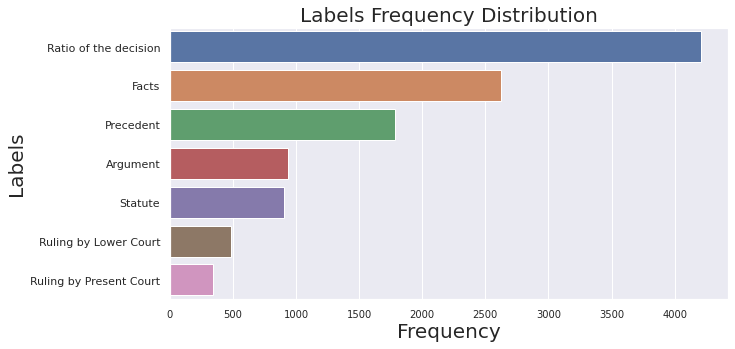

In [26]:
sns.set_theme(style="darkgrid")
x = dataset1['labels'].value_counts()
y = x.index
plt.figure(figsize=(10, 5))
g = sns.barplot(x=x, y=y)
plt.title("Labels Frequency Distribution", fontsize=20)
plt.ylabel('Labels', fontsize= 20)
plt.yticks(fontsize=11)
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=10)
plt.show()

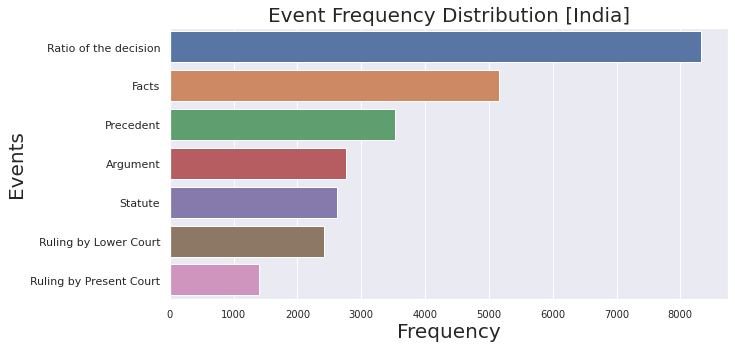

In [27]:
sns.set_theme(style="darkgrid")
x = balanced_df.Labels.value_counts()
y = x.index
plt.figure(figsize=(10, 5))
g = sns.barplot(x=x, y=y)
plt.title("Event Frequency Distribution [India]", fontsize=20)
plt.ylabel('Events', fontsize= 20)
plt.yticks(fontsize=11)
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=10)
plt.show()

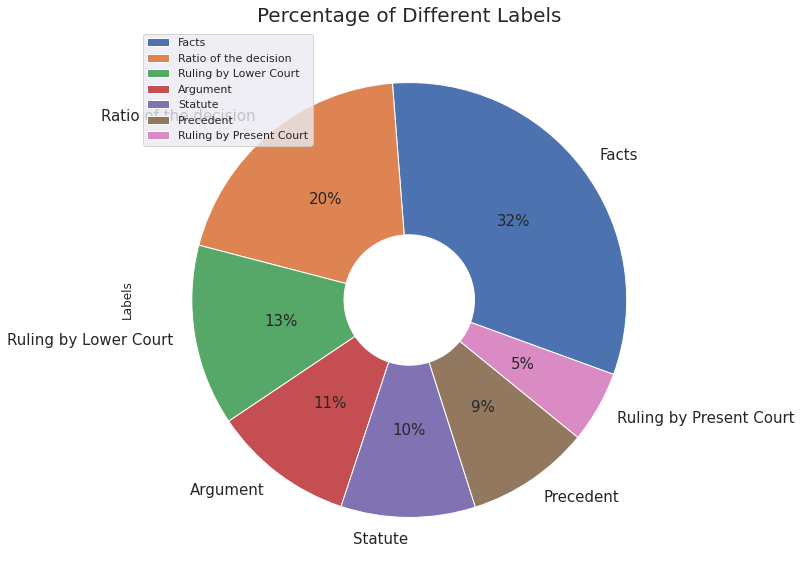

In [28]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Different Labels', fontsize=20)
balanced_df.Labels.value_counts().plot(kind='pie', labels= balanced_df.Labels.unique(),
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})
plt.legend(loc='upper left')
plt.show()

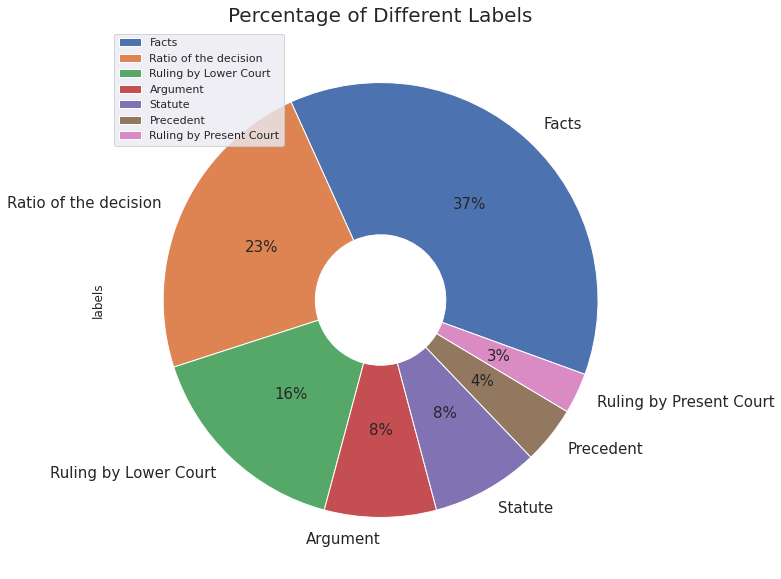

In [29]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Different Labels', fontsize=20)
dataset1.labels.value_counts().plot(kind='pie', labels= dataset1.labels.unique(),
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})
plt.legend(loc='upper left')
plt.show()

# **BERT**

**Tokenization**

In [30]:
max_classes = len(balanced_df.Labels.unique())

In [31]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
result = shuffle(balanced_df)
from sklearn.model_selection import KFold

In [32]:
#X_train, X_test, Y_train, Y_test = train_test_split(balanced_df.Text, balanced_df.NumLabel, test_size = 0.1, random_state = 42, stratify =balanced_df.NumLabel)


kf = KFold(n_splits=3)
kf.get_n_splits(result.Text)
print(kf)
KFold(n_splits=3, random_state=None, shuffle=False)

for train_index, test_index in kf.split(result.Text):
     print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = result.Text[train_index], result.Text[test_index]
     y_train, y_test = result.NumLabel[train_index], result.NumLabel[test_index]
     print(X_train, X_test, y_train, y_test)


KFold(n_splits=3, random_state=None, shuffle=False)
TRAIN: [ 8733  8734  8735 ... 26195 26196 26197] TEST: [   0    1    2 ... 8730 8731 8732]
8733     clear s. andhra pradesh act mention acquisitio...
8734     noticed u hereinbefore rule rule applicable in...
8735     also seems scuffle bhavnawhich apparent fact h...
8736     s. contemplates issuance notice prescribed man...
8737     stated therein neither draft constitution prep...
                               ...                        
26193    no. th january. held since question whether pe...
26194                                   appellant no. bail
26195    first contention appellant therefore fails hol...
26196    doeshoweverfacilitate remedy enforced obtained...
26197       appeal disposed accordingly without order cost
Name: Text, Length: 17465, dtype: object 0       forensic science laboratory confirmed presence...
1       proceeded house accused situated village kolhu...
2                       however unable obtain infor

In [33]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'
bert_model_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_model_preprocessing_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [34]:
bert_preprocess_model = hub.KerasLayer(bert_model_preprocessing_link)

In [35]:
bert_model = hub.KerasLayer(bert_model_link)

In [36]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype = tf.string, name='input-text')
    preprocessing_layer = hub.KerasLayer(bert_model_preprocessing_link, name='bert-preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(bert_model_link, trainable=True, name='bert-encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = Dense(units= 512, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = Dense(units=max_classes, activation='softmax', name='classifer')(net)
    return tf.keras.Model(text_input, net)

In [37]:
classifier_model = build_classifier_model()
# bert_raw_result = classifier_model(tf.constant(sample_text))

In [38]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input-text (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 bert-preprocessing (KerasLayer  {'input_mask': (Non  0          ['input-text[0][0]']             
 )                              e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  


**Label** **Encoding**

In [39]:
max_classes = len(balanced_df.Labels.unique())


# **Hyperparameters**

In [40]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

EPOCHS = 3
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
batch_size = 32

num_train_steps =  len((balanced_df.NumLabel) // batch_size) * EPOCHS
lr_scheduler = PolynomialDecay(initial_learning_rate=5e-5,
                               end_learning_rate=0.,
                               decay_steps=num_train_steps
                               )

from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=lr_scheduler)

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
!mkdir checkpoints

MyCheckpoint = ModelCheckpoint('/content/checkpoints',
                               monitor = 'val_categorical_accuracy',
                               verbose = 1,
                               save_best_only = True,
                               save_weights_only = False)

MyEarlyStopping = EarlyStopping(patience =1,
                                monitor='val_categorical_accuracy',
                                restore_best_weights = True,
                                verbose = 1)

import os
os.path.exists('/content/checkpoints')

True

# **Class Weight Balancing**

In [42]:
from sklearn.utils import class_weight
class_weights_array = class_weight.compute_class_weight(class_weight='balanced'
                                               ,classes=np.unique(balanced_df.NumLabel)
                                               ,y=balanced_df.NumLabel)

class_weights_array

array([0.72474272, 0.44939618, 1.5529342 , 1.3589584 , 1.4290078 ,
       1.06081957, 2.6828469 ])

In [43]:
class_weights = {i : class_weights_array[i] for i in range(len(class_weights_array))}
class_weights

{0: 0.7247427243554276,
 1: 0.4493961849869631,
 2: 1.5529342027267339,
 3: 1.3589583981740845,
 4: 1.4290078001418207,
 5: 1.0608195659216066,
 6: 2.682846902201741}

# **Building Model**

In [44]:
import tensorflow_addons as tfa

macro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='macro')
micro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='micro')
weighted_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='weighted')
precision = tf.metrics.Precision()
recall = tf.metrics.Recall()
categorical_accuracry = tf.metrics.CategoricalAccuracy()

metrics = [categorical_accuracry, micro_f1, precision, recall]

In [45]:
classifier_model.compile(optimizer= opt,
              loss= loss,
              metrics = metrics)

In [46]:
kf = KFold(n_splits=3)
kf.get_n_splits(result.Text)
print(kf)
KFold(n_splits=3, random_state=None, shuffle=False)

for train_index, test_index in kf.split(result.Text):
     print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = result.Text[train_index], result.Text[test_index]
     Y_train, Y_test = result.NumLabel[train_index], result.NumLabel[test_index]
     encoded_labels_train = to_categorical(Y_train, num_classes=max_classes)
     encoded_labels_test = to_categorical(Y_test, num_classes=max_classes)
     train_dataset = tf.data.Dataset.from_tensor_slices((X_train, encoded_labels_train)).shuffle(70000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
     test_dataset = tf.data.Dataset.from_tensor_slices((X_test, encoded_labels_test)).shuffle(70000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
     classifier_model.fit(train_dataset,
                     validation_data=test_dataset,
                 epochs = EPOCHS,
                 verbose = 1,
                 class_weight=class_weights,
                 callbacks = [MyCheckpoint, MyEarlyStopping]
          )




KFold(n_splits=3, random_state=None, shuffle=False)
TRAIN: [ 8733  8734  8735 ... 26195 26196 26197] TEST: [   0    1    2 ... 8730 8731 8732]
Epoch 1/3
546/546 [==============================] - ETA: 0s - loss: 1.1983 - categorical_accuracy: 0.5279 - f1_score: 0.5279 - precision: 0.7103 - recall: 0.3930
Epoch 00001: val_categorical_accuracy improved from -inf to 0.16558, saving model to /content/checkpoints


INFO:tensorflow:Assets written to: /content/checkpoints/assets


INFO:tensorflow:Assets written to: /content/checkpoints/assets


546/546 [==============================] - 1084s 2s/step - loss: 1.1983 - categorical_accuracy: 0.5279 - f1_score: 0.5279 - precision: 0.7103 - recall: 0.3930 - val_loss: 4.7584 - val_categorical_accuracy: 0.1656 - val_f1_score: 0.1656 - val_precision: 0.1400 - val_recall: 0.0963
Epoch 2/3
546/546 [==============================] - ETA: 0s - loss: 0.3941 - categorical_accuracy: 0.8007 - f1_score: 0.8007 - precision: 0.8268 - recall: 0.7651
Epoch 00002: val_categorical_accuracy improved from 0.16558 to 0.24093, saving model to /content/checkpoints


INFO:tensorflow:Assets written to: /content/checkpoints/assets


INFO:tensorflow:Assets written to: /content/checkpoints/assets


546/546 [==============================] - 1058s 2s/step - loss: 0.3941 - categorical_accuracy: 0.8007 - f1_score: 0.8007 - precision: 0.8268 - recall: 0.7651 - val_loss: 5.2295 - val_categorical_accuracy: 0.2409 - val_f1_score: 0.2409 - val_precision: 0.2512 - val_recall: 0.2267
Epoch 3/3
546/546 [==============================] - ETA: 0s - loss: 0.1954 - categorical_accuracy: 0.9021 - f1_score: 0.9021 - precision: 0.9084 - recall: 0.8951
Epoch 00003: val_categorical_accuracy improved from 0.24093 to 0.35394, saving model to /content/checkpoints


INFO:tensorflow:Assets written to: /content/checkpoints/assets


INFO:tensorflow:Assets written to: /content/checkpoints/assets


546/546 [==============================] - 1052s 2s/step - loss: 0.1954 - categorical_accuracy: 0.9021 - f1_score: 0.9021 - precision: 0.9084 - recall: 0.8951 - val_loss: 6.0910 - val_categorical_accuracy: 0.3539 - val_f1_score: 0.3539 - val_precision: 0.3578 - val_recall: 0.3505
TRAIN: [    0     1     2 ... 26195 26196 26197] TEST: [ 8733  8734  8735 ... 17463 17464 17465]
Epoch 1/3
546/546 [==============================] - ETA: 0s - loss: 0.3471 - categorical_accuracy: 0.8147 - f1_score: 0.8147 - precision: 0.8345 - recall: 0.7905
Epoch 00001: val_categorical_accuracy improved from 0.35394 to 0.52033, saving model to /content/checkpoints


INFO:tensorflow:Assets written to: /content/checkpoints/assets


INFO:tensorflow:Assets written to: /content/checkpoints/assets


546/546 [==============================] - 1050s 2s/step - loss: 0.3471 - categorical_accuracy: 0.8147 - f1_score: 0.8147 - precision: 0.8345 - recall: 0.7905 - val_loss: 1.8670 - val_categorical_accuracy: 0.5203 - val_f1_score: 0.5203 - val_precision: 0.5229 - val_recall: 0.5009
Epoch 2/3
546/546 [==============================] - ETA: 0s - loss: 0.1802 - categorical_accuracy: 0.9013 - f1_score: 0.9013 - precision: 0.9092 - recall: 0.8946
Epoch 00002: val_categorical_accuracy improved from 0.52033 to 0.66655, saving model to /content/checkpoints


INFO:tensorflow:Assets written to: /content/checkpoints/assets


INFO:tensorflow:Assets written to: /content/checkpoints/assets


546/546 [==============================] - 1066s 2s/step - loss: 0.1802 - categorical_accuracy: 0.9013 - f1_score: 0.9013 - precision: 0.9092 - recall: 0.8946 - val_loss: 2.0444 - val_categorical_accuracy: 0.6666 - val_f1_score: 0.6666 - val_precision: 0.6697 - val_recall: 0.6637
Epoch 3/3
546/546 [==============================] - ETA: 0s - loss: 0.1153 - categorical_accuracy: 0.9405 - f1_score: 0.9405 - precision: 0.9447 - recall: 0.9365
Epoch 00003: val_categorical_accuracy did not improve from 0.66655
Restoring model weights from the end of the best epoch: 2.
546/546 [==============================] - 1037s 2s/step - loss: 0.1153 - categorical_accuracy: 0.9405 - f1_score: 0.9405 - precision: 0.9447 - recall: 0.9365 - val_loss: 2.2347 - val_categorical_accuracy: 0.6440 - val_f1_score: 0.6440 - val_precision: 0.6502 - val_recall: 0.6412
Epoch 00003: early stopping
TRAIN: [    0     1     2 ... 17463 17464 17465] TEST: [17466 17467 17468 ... 26195 26196 26197]
Epoch 1/3
546/546 [=====

In [47]:
classifier_model.save('BERT-Model.h5')

# **Testing**

In [48]:
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Task1_Test/'
list_dir = os.listdir(PATH)
text = []
labels = []
sentid = []
i=0
for file in list_dir:
    file_path = PATH + file
    j=1
    i=i+1
    with open(file_path, 'r') as f:
        for line in f:
            line = line.split(sep='\t')
            text.append(line[0])
            labels.append(line[1][:-1])
            sentid.append("d"+str(i)+"_s"+str(j))
            j=j+1

data = {'ID': sentid, 'Text': text, "labels": labels}
test_file = pd.DataFrame(data=data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# Remove Excess [Size:: ] from EoS
def remove_size(text):
	result = re.search("\[size", text)
	if result is not None:
		text = text[:result.start()]
	return text.strip()

months = ['january', 'jan', 'feb', 'mar', 'apr', 'aug', 'sept', 'oct', 'nov', 'dec', 'feburary', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'on']
def remove_months(text):
    text = text.split()
    text = [word for word in text if word.lower() not in set(months)]
    text = ' '.join(text)
    return text

def remove_nums(text):
    result = re.sub(r'[0-9+]', '', text)
    return result

def remove_comma(text):
    result = re.sub(r',', '', text)
    return result

In [50]:
def text_cleaning(text):
    text = remove_size(text)
    text = remove_nums(text)
    text = remove_months(text)
    text = remove_comma(text)
    return text.strip().lower()

test_file['processed'] = test_file['Text'].apply(text_cleaning)

In [51]:
test_file

,ID,Text,labels,processed
0,d1_s1,State of Madhya Pradesh runs an establishment ...,Facts,state of madhya pradesh runs an establishment ...
1,d1_s2,Respondent was appointed on temporary basis fr...,Facts,respondent was appointed temporary basis from ...
2,d1_s3,He worked for the period 13.12.1991 to 1.3.1994.,Facts,he worked for the period .. to ...
3,d1_s4,"After his services were terminated, an industr...",Facts,after his services were terminated an industri...
4,d1_s5,The said dispute was referred for its determin...,Facts,the said dispute was referred for its determin...
...,...,...,...,...
692,d10_s109,The learned counsel for the respondent was how...,Ratio of the decision,the learned counsel for the respondent was how...
693,d10_s110,It is not necessary to consider the decisions ...,Ratio of the decision,it is not necessary to consider the decisions ...
694,d10_s111,"In the result, both the Criminal Appeals are a...",Ruling by Present Court,in the result both the criminal appeals are al...
695,d10_s112,The Criminal Case no. SW/332 of 2011 pending b...,Ruling by Present Court,the criminal case no. sw/ of pending before th...


In [52]:
lemmatizer = WordNetLemmatizer()
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
def lemmatizing_headlines(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in set(stopwords.words('english'))]
    return ' '.join(tokens).strip()

test_file['processed'] = test_file['processed'].apply(lemmatizing_headlines)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
test_file.head()

,ID,Text,labels,processed
0,d1_s1,State of Madhya Pradesh runs an establishment ...,Facts,state madhya pradesh run establishment delhi k...
1,d1_s2,Respondent was appointed on temporary basis fr...,Facts,respondent appointed temporary basis time time...
2,d1_s3,He worked for the period 13.12.1991 to 1.3.1994.,Facts,worked period .. ...
3,d1_s4,"After his services were terminated, an industr...",Facts,service terminated industrial dispute raised .
4,d1_s5,The said dispute was referred for its determin...,Facts,said dispute referred determination industrial...


In [54]:
y_preds = np.argmax(classifier_model.predict(test_file.processed), axis=1)

In [55]:
y_preds

array([0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 3, 3, 3, 0, 3, 3, 2, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 0, 1, 0, 3, 1, 1, 1, 2, 2, 1, 2, 0,
       0, 1, 1, 1, 1, 3, 0, 1, 3, 1, 1, 1, 1, 2, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 2, 2, 1, 1, 0, 3, 1, 2, 6, 6, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 2, 1, 0, 0, 0, 0, 0, 3, 3, 1, 0, 2, 1,
       1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 3, 0, 2, 1, 2, 2, 0, 0, 1, 0,
       0, 3, 3, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 0, 1, 2,
       1, 6, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 1, 3, 3, 1, 3, 0, 3, 3,
       0, 0, 2, 0, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 1, 1, 1, 4, 4, 0, 1, 1, 4, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0,

In [56]:
test_file['pred-labels'] = y_preds

In [57]:
test_file.head()

,ID,Text,labels,processed,pred-labels
0,d1_s1,State of Madhya Pradesh runs an establishment ...,Facts,state madhya pradesh run establishment delhi k...,0
1,d1_s2,Respondent was appointed on temporary basis fr...,Facts,respondent appointed temporary basis time time...,0
2,d1_s3,He worked for the period 13.12.1991 to 1.3.1994.,Facts,worked period .. ...,0
3,d1_s4,"After his services were terminated, an industr...",Facts,service terminated industrial dispute raised .,0
4,d1_s5,The said dispute was referred for its determin...,Facts,said dispute referred determination industrial...,0


In [58]:
def num_to_text_labels(num):
    text = event_types_dict_inverse[num]
    return text

test_file['text_labels'] = test_file['pred-labels'].apply(num_to_text_labels)

In [59]:
test_file

,ID,Text,labels,processed,pred-labels,text_labels
0,d1_s1,State of Madhya Pradesh runs an establishment ...,Facts,state madhya pradesh run establishment delhi k...,0,Facts
1,d1_s2,Respondent was appointed on temporary basis fr...,Facts,respondent appointed temporary basis time time...,0,Facts
2,d1_s3,He worked for the period 13.12.1991 to 1.3.1994.,Facts,worked period .. ...,0,Facts
3,d1_s4,"After his services were terminated, an industr...",Facts,service terminated industrial dispute raised .,0,Facts
4,d1_s5,The said dispute was referred for its determin...,Facts,said dispute referred determination industrial...,0,Facts
...,...,...,...,...,...,...
692,d10_s109,The learned counsel for the respondent was how...,Ratio of the decision,learned counsel respondent however right submi...,3,Argument
693,d10_s110,It is not necessary to consider the decisions ...,Ratio of the decision,necessary consider decision cited respondent p...,1,Ratio of the decision
694,d10_s111,"In the result, both the Criminal Appeals are a...",Ruling by Present Court,result criminal appeal allowed .,6,Ruling by Present Court
695,d10_s112,The Criminal Case no. SW/332 of 2011 pending b...,Ruling by Present Court,criminal case . sw/ pending learned metropolit...,0,Facts


                         precision    recall  f1-score   support

               Argument       0.66      0.71      0.68        56
                  Facts       0.45      0.69      0.54       154
              Precedent       0.50      0.01      0.02        79
  Ratio of the decision       0.61      0.57      0.59       314
  Ruling by Lower Court       0.16      0.60      0.26        25
Ruling by Present Court       1.00      0.17      0.30        40
                Statute       0.83      0.17      0.29        29

               accuracy                           0.51       697
              macro avg       0.60      0.42      0.38       697
           weighted avg       0.58      0.51      0.48       697



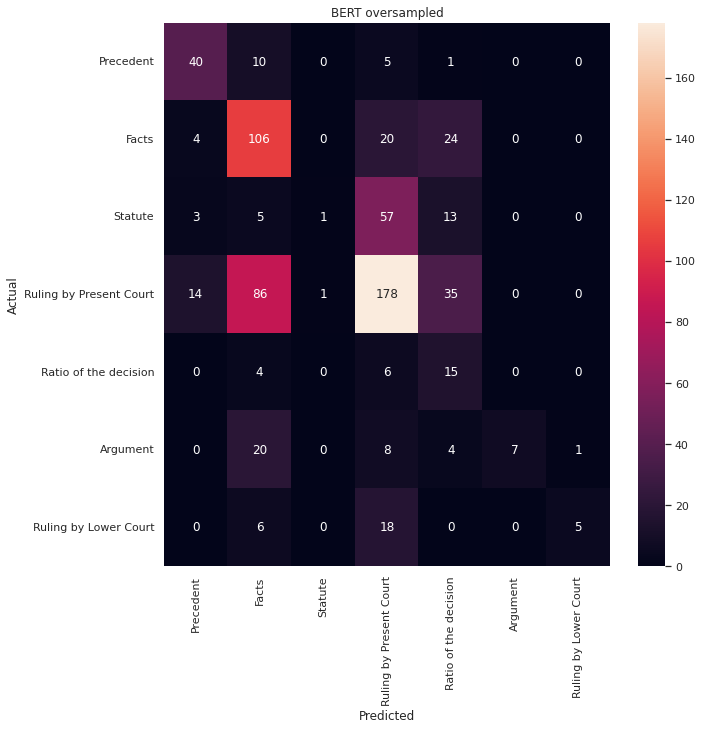

In [60]:
from sklearn.metrics import classification_report
print(classification_report(test_file.labels,test_file.text_labels))

import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(list(test_file.labels), list(test_file['text_labels']))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(test_file.labels), yticklabels=set(test_file.labels))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('BERT oversampled')
plt.show()

In [61]:
run=["nit_agartala_nlp_team_1"]*697
test_file['run_id']=run
test_file.rename(columns = {'ID':'docid_sentid', 'text-labels':'label'}, inplace = True)
test_file

,docid_sentid,Text,labels,processed,pred-labels,text_labels,run_id
0,d1_s1,State of Madhya Pradesh runs an establishment ...,Facts,state madhya pradesh run establishment delhi k...,0,Facts,nit_agartala_nlp_team_1
1,d1_s2,Respondent was appointed on temporary basis fr...,Facts,respondent appointed temporary basis time time...,0,Facts,nit_agartala_nlp_team_1
2,d1_s3,He worked for the period 13.12.1991 to 1.3.1994.,Facts,worked period .. ...,0,Facts,nit_agartala_nlp_team_1
3,d1_s4,"After his services were terminated, an industr...",Facts,service terminated industrial dispute raised .,0,Facts,nit_agartala_nlp_team_1
4,d1_s5,The said dispute was referred for its determin...,Facts,said dispute referred determination industrial...,0,Facts,nit_agartala_nlp_team_1
...,...,...,...,...,...,...,...
692,d10_s109,The learned counsel for the respondent was how...,Ratio of the decision,learned counsel respondent however right submi...,3,Argument,nit_agartala_nlp_team_1
693,d10_s110,It is not necessary to consider the decisions ...,Ratio of the decision,necessary consider decision cited respondent p...,1,Ratio of the decision,nit_agartala_nlp_team_1
694,d10_s111,"In the result, both the Criminal Appeals are a...",Ruling by Present Court,result criminal appeal allowed .,6,Ruling by Present Court,nit_agartala_nlp_team_1
695,d10_s112,The Criminal Case no. SW/332 of 2011 pending b...,Ruling by Present Court,criminal case . sw/ pending learned metropolit...,0,Facts,nit_agartala_nlp_team_1


In [62]:
test_file = test_file.drop(['Text', 'labels', 'processed', 'pred-labels'], axis=1)

In [63]:
test_file.to_csv('nit_agartala_nlp_team_1.tsv', sep='\t', index=False)

In [64]:
trrr = pd.read_csv('nit_agartala_nlp_team_1.tsv', sep='\t')

In [65]:
trrr.head()

,docid_sentid,text_labels,run_id
0,d1_s1,Facts,nit_agartala_nlp_team_1
1,d1_s2,Facts,nit_agartala_nlp_team_1
2,d1_s3,Facts,nit_agartala_nlp_team_1
3,d1_s4,Facts,nit_agartala_nlp_team_1
4,d1_s5,Facts,nit_agartala_nlp_team_1
